In [1]:
import os
import re
import subprocess
from tqdm import tqdm

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Print the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /u/dzhou2/Project/CUDA-project-for-IE533/Code


In [3]:
! make clean
! make all 

rm -fr ./main.o ./lib/cuda/cuda_ssp.o ./lib/ssp.o ./lib/cuda/cuda_ssp.d ./main.d ./lib/ssp.d stochastic_shortest_path
 
NVCC compiler building file: main.cpp
nvcc -O3 -std=c++11 -gencode arch=compute_61,code=sm_61  -odir "." -M -o "main.d" "main.cpp"
nvcc -O3 -std=c++11 --compile  -x c++ -o  "main.o" "main.cpp"
Finished building: main.cpp
 
NVCC compiler building file: lib/cuda/cuda_ssp.cu
nvcc -O3 -std=c++11 -gencode arch=compute_61,code=sm_61  -odir "lib/cuda" -M -o "lib/cuda/cuda_ssp.d" "lib/cuda/cuda_ssp.cu"
nvcc -O3 -std=c++11 --compile --relocatable-device-code=false -gencode arch=compute_61,code=compute_61 -gencode arch=compute_61,code=sm_61  -x cu -o  "lib/cuda/cuda_ssp.o" "lib/cuda/cuda_ssp.cu"
Finished building: lib/cuda/cuda_ssp.cu
 
NVCC compiler building file: lib/ssp.cpp
nvcc -O3 -std=c++11 -gencode arch=compute_61,code=sm_61  -odir "lib" -M -o "lib/ssp.d" "lib/ssp.cpp"
nvcc -O3 -std=c++11 --compile  -x c++ -o  "lib/ssp.o" "lib/ssp.cpp"
Finished building: lib/ssp.cpp
 
Li

In [4]:
folder_path = './data/'

graphs = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

def get_number(s):
    return int(s.split('-')[1][1:])

big_graphs = sorted(graphs, key=get_number)

print(big_graphs)

['V1000-E150000', 'V2000-E400000', 'V5000-E500000', 'V7500-E1125000', 'V10000-E2000000', 'V12500-E3125000']


In [5]:
commands = []
outputs = {"Vertices #": ['V1000', 'V2000', 'V5000', 'V7500', 'V10000', 'V12500'],
    "Edges #": ['E150000', 'E400000', 'E500000', 'E1125000', 'E2000000', 'E3125000'],
    0: [],
    1: [],
    2: []} 

for i in tqdm(range(len(big_graphs)), desc= f'Graph'):
    for Algorithm in tqdm(range(3), desc=f'Algorithm'):
        command = f"./stochastic_shortest_path -a {Algorithm} < ./data/{big_graphs[i]}"
        commands.append(command)
        outputs[Algorithm].append(subprocess.check_output(command, shell=True))
        
my_dict = outputs

Graph: 100%|██████████| 6/6 [40:28<00:00, 404.68s/it]


# Computing Time Organization

In [6]:
for key in [0, 1, 2]:
    my_dict[key] = [int(s.split()[2]) for s in my_dict[key]]

new_keys = {
    0: "compute_time of C++",
    1: "compute_time of CUDA",
    2: "compute_time of Parallel CUDA"
}

for old_key, new_key in new_keys.items():
    my_dict[new_key] = my_dict.pop(old_key)

print(my_dict)

{'Vertices #': ['V1000', 'V2000', 'V5000', 'V7500', 'V10000', 'V12500'], 'Edges #': ['E150000', 'E400000', 'E500000', 'E1125000', 'E2000000', 'E3125000'], 'compute_time of C++': [626, 5446, 83686, 277099, 651600, 1264029], 'compute_time of CUDA': [286, 348, 1330, 3646, 8086, 15295], 'compute_time of Well Designed CUDA': [182, 200, 442, 1038, 2189, 4192]}


In [2]:
# RECORD THE COMPUTATION TIME in Intel Core i5 12600KF and NVIDIA RTX 3070
record1 = {
    "Vertices #": ['V1000', 'V2000', 'V5000', 'V7500', 'V10000', 'V12500'],
    "Edges #": ['E150000', 'E400000', 'E500000', 'E1125000', 'E2000000', 'E3125000'],
    "compute_time of C++": [380, 3518, 54874, 183425, 428358, 840263],
    "compute_time of CUDA": [313, 384, 1820, 5223, 12228, 24836],
    "compute_time of Parallel CUDA": [304, 295, 721, 1573, 3303, 7092],
}

# RECORD THE COMPUTATION TIME in AMD EPYC 7763 and NVIDIA Tesla A40
record2 = {
    'Vertices #': ['V1000', 'V2000', 'V5000', 'V7500', 'V10000', 'V12500'],
    'Edges #': ['E150000', 'E400000', 'E500000', 'E1125000', 'E2000000', 'E3125000'],
    "compute_time of C++": [631, 5497, 83629, 279246, 654833, 1268138],
    "compute_time of CUDA": [261, 371, 1329, 3655, 8100, 15326],
    "compute_time of Parallel CUDA": [165, 202, 442, 1034, 2185, 4190]
}

# Visualization

In [3]:
df = pd.DataFrame(record1)

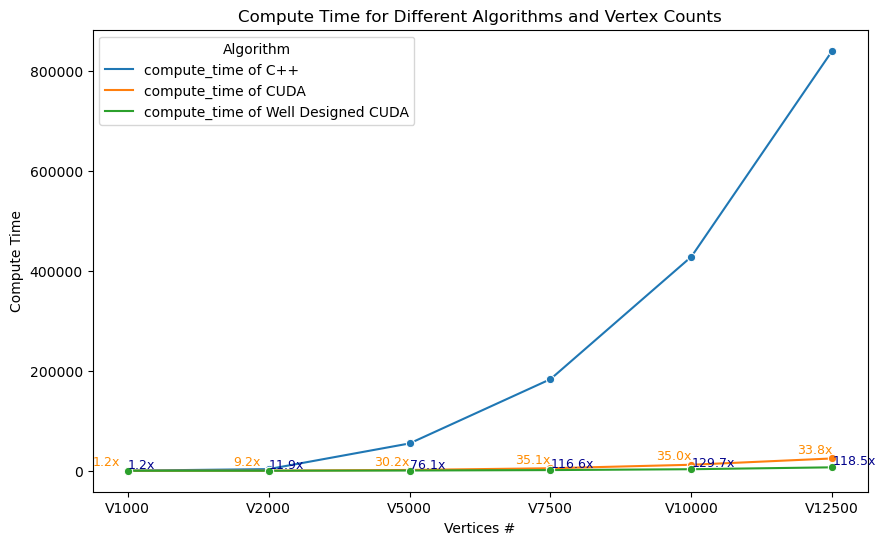

In [4]:
df_melted = df.melt(id_vars=['Vertices #', 'Edges #'], var_name='Algorithm', value_name='Compute Time')

# Calculate the speedup factor
speedup_cuda = [cpp_time / cuda_time for cpp_time, cuda_time in zip(df['compute_time of C++'], df['compute_time of CUDA'])]
speedup_well_designed_cuda = [cpp_time / well_designed_cuda_time for cpp_time, well_designed_cuda_time in zip(df['compute_time of C++'], df['compute_time of Parallel CUDA'])]

# Line plot with speedup annotations
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Vertices #', y='Compute Time', hue='Algorithm', marker='o')
plt.title("Compute Time for Different Algorithms and Vertex Counts")

# Add speedup annotations to the plot
for i, (speedup1, speedup2) in enumerate(zip(speedup_cuda, speedup_well_designed_cuda)):
    plt.annotate(f"{speedup1:.1f}x", (i - 0.25, df['compute_time of CUDA'][i] + 10000), fontsize=9, color='darkorange')
    plt.annotate(f"{speedup2:.1f}x", (i, df['compute_time of Parallel CUDA'][i] + 5000), fontsize=9, color='darkblue')

plt.show()

In [ ]:
record1 = {
    "Vertices #": ['V1000', 'V2000', 'V5000', 'V7500', 'V10000', 'V12500'],
    "Edges #": ['E150000', 'E400000', 'E500000', 'E1125000', 'E2000000', 'E3125000'],
    "compute_time of C++": [380, 3518, 54874, 183425, 428358, 840263],
    "compute_time of CUDA": [313, 384, 1820, 5223, 12228, 24836],
    "compute_time of Parallel CUDA": [304, 295, 721, 1573, 3303, 7092],
}

df = pd.DataFrame(record1)

# Calculate speedup compared to C++
df['CUDA_speedup'] = df['compute_time of C++'] / df['compute_time of CUDA']
df['Parallel CUDA_speedup'] = df['compute_time of CUDA'] / df['compute_time of Parallel CUDA']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Compute Time for Different Algorithms and Edge Counts")

sns.lineplot(ax=axes[0], data=df, x='Edges #', y='compute_time of C++', marker='o', color='darkgreen')
axes[0].set_title("C++")
axes[0].set_ylabel("Compute Time")
axes[0].set_xticklabels(df['Edges #'], rotation=45)

sns.lineplot(ax=axes[1], data=df, x='Edges #', y='compute_time of CUDA', marker='o', color='darkorange')
axes[1].set_title("CUDA")
axes[1].set_ylabel("")
axes[1].set_xticklabels(df['Edges #'], rotation=45)

sns.lineplot(ax=axes[2], data=df, x='Edges #', y='compute_time of Parallel CUDA', marker='o', color='darkblue')
axes[2].set_title("Parallel CUDA")
axes[2].set_ylabel("")
axes[2].set_xticklabels(df['Edges #'], rotation=45)

# Annotate speedup compared to C++
for i, row in df.iterrows():
    axes[1].text(row['Edges #'], row['compute_time of CUDA'], f"{row['CUDA_speedup']:.1f}x", ha='center', va='bottom')
    axes[2].text(row['Edges #'], row['compute_time of Parallel CUDA'], f"{row['Parallel CUDA_speedup']:.1f}x", ha='center', va='bottom')

plt.show()

# Visualizion for Log Data

/tmp/ipykernel_2771302/2782761339.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df['Edges #'], rotation=45)
/tmp/ipykernel_2771302/2782761339.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df['Edges #'], rotation=45)
/tmp/ipykernel_2771302/2782761339.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(df['Edges #'], rotation=45)


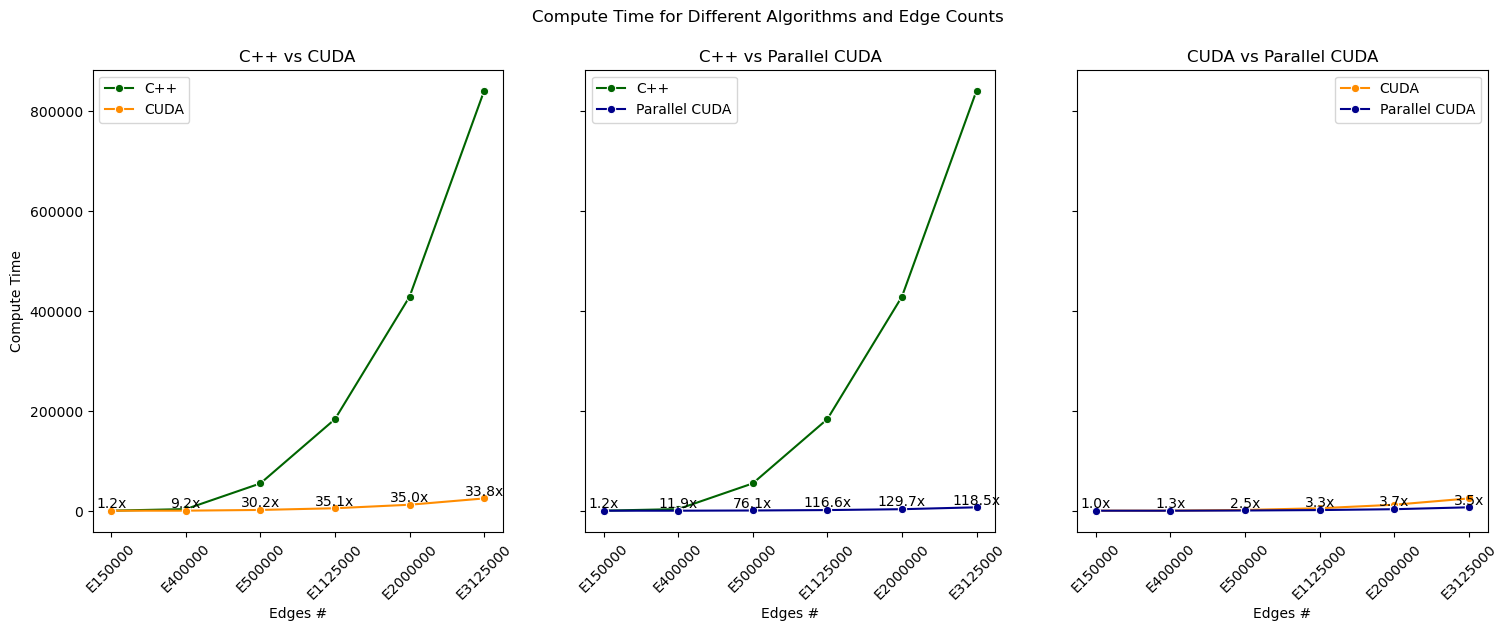

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

record1 = {
    "Vertices #": ['V1000', 'V2000', 'V5000', 'V7500', 'V10000', 'V12500'],
    "Edges #": ['E150000', 'E400000', 'E500000', 'E1125000', 'E2000000', 'E3125000'],
    "compute_time of C++": [380, 3518, 54874, 183425, 428358, 840263],
    "compute_time of CUDA": [313, 384, 1820, 5223, 12228, 24836],
    "compute_time of Parallel CUDA": [304, 295, 721, 1573, 3303, 7092],
}

df = pd.DataFrame(record1)

# Calculate speedup compared to C++
df['CUDA_speedup'] = df['compute_time of C++'] / df['compute_time of CUDA']
df['Parallel CUDA_speedup'] = df['compute_time of C++'] / df['compute_time of Parallel CUDA']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Compute Time for Different Algorithms and Edge Counts")

# C++ vs CUDA
sns.lineplot(ax=axes[0], data=df, x='Edges #', y='compute_time of C++', marker='o', color='darkgreen', label="C++")
sns.lineplot(ax=axes[0], data=df, x='Edges #', y='compute_time of CUDA', marker='o', color='darkorange', label="CUDA")
axes[0].set_title("C++ vs CUDA")
axes[0].set_ylabel("Compute Time")
axes[0].set_xticklabels(df['Edges #'], rotation=45)
axes[0].legend()

# C++ vs Parallel CUDA
sns.lineplot(ax=axes[1], data=df, x='Edges #', y='compute_time of C++', marker='o', color='darkgreen', label="C++")
sns.lineplot(ax=axes[1], data=df, x='Edges #', y='compute_time of Parallel CUDA', marker='o', color='darkblue', label="Parallel CUDA")
axes[1].set_title("C++ vs Parallel CUDA")
axes[1].set_ylabel("")
axes[1].set_xticklabels(df['Edges #'], rotation=45)
axes[1].legend()

# CUDA vs Parallel CUDA
sns.lineplot(ax=axes[2], data=df, x='Edges #', y='compute_time of CUDA', marker='o', color='darkorange', label="CUDA")
sns.lineplot(ax=axes[2], data=df, x='Edges #', y='compute_time of Parallel CUDA', marker='o', color='darkblue', label="Parallel CUDA")
axes[2].set_title("CUDA vs Parallel CUDA")
axes[2].set_ylabel("")
axes[2].set_xticklabels(df['Edges #'], rotation=45)
axes[2].legend()

# Annotate speedup values
for i, row in df.iterrows():
    axes[0].text(row['Edges #'], row['compute_time of CUDA'], f"{row['CUDA_speedup']:.1f}x", ha='center', va='bottom')
    axes[1].text(row['Edges #'], row['compute_time of Parallel CUDA'], f"{row['Parallel CUDA_speedup']:.1f}x", ha='center', va='bottom')
    axes[2].text(row['Edges #'], row['compute_time of Parallel CUDA'], f"{(row['compute_time of CUDA'] / row['compute_time of Parallel CUDA']):.1f}x", ha='center', va='bottom')

plt.show()



In [3]:
df

,Vertices #,Edges #,compute_time of C++,compute_time of CUDA,compute_time of Well Designed CUDA,CUDA_speedup,Well Designed CUDA_speedup
0,V1000,E150000,380,313,304,1.214058,1.250000
1,V2000,E400000,3518,384,295,9.161458,11.925424
2,V5000,E500000,54874,1820,721,30.150549,76.108183
3,V7500,E1125000,183425,5223,1573,35.118706,116.608392
4,V10000,E2000000,428358,12228,3303,35.030913,129.687557
5,V12500,E3125000,840263,24836,7092,33.832461,118.480400


/tmp/ipykernel_2771302/1409759277.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(df['Edges #'], rotation=45)
/tmp/ipykernel_2771302/1409759277.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(df['Edges #'], rotation=45)
/tmp/ipykernel_2771302/1409759277.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(df['Edges #'], rotation=45)


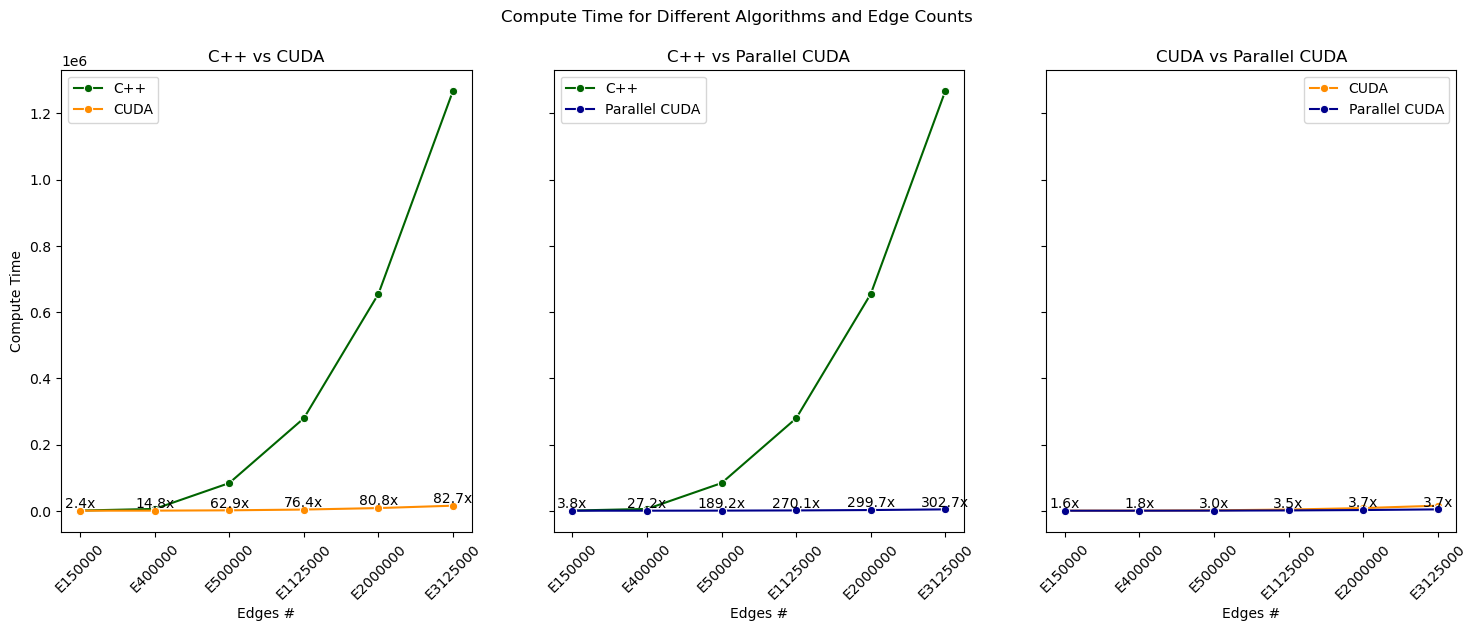

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

record2 = {
    'Vertices #': ['V1000', 'V2000', 'V5000', 'V7500', 'V10000', 'V12500'],
    'Edges #': ['E150000', 'E400000', 'E500000', 'E1125000', 'E2000000', 'E3125000'],
    "compute_time of C++": [631, 5497, 83629, 279246, 654833, 1268138],
    "compute_time of CUDA": [261, 371, 1329, 3655, 8100, 15326],
    "compute_time of Parallel CUDA": [165, 202, 442, 1034, 2185, 4190]
}

df = pd.DataFrame(record2)

# Calculate speedup compared to C++
df['CUDA_speedup'] = df['compute_time of C++'] / df['compute_time of CUDA']
df['Parallel CUDA_speedup'] = df['compute_time of C++'] / df['compute_time of Parallel CUDA']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle("Compute Time for Different Algorithms and Edge Counts")

# C++ vs CUDA
sns.lineplot(ax=axes[0], data=df, x='Edges #', y='compute_time of C++', marker='o', color='darkgreen', label="C++")
sns.lineplot(ax=axes[0], data=df, x='Edges #', y='compute_time of CUDA', marker='o', color='darkorange', label="CUDA")
axes[0].set_title("C++ vs CUDA")
axes[0].set_ylabel("Compute Time")
axes[0].set_xticklabels(df['Edges #'], rotation=45)
axes[0].legend()

# C++ vs Parallel CUDA
sns.lineplot(ax=axes[1], data=df, x='Edges #', y='compute_time of C++', marker='o', color='darkgreen', label="C++")
sns.lineplot(ax=axes[1], data=df, x='Edges #', y='compute_time of Parallel CUDA', marker='o', color='darkblue', label="Parallel CUDA")
axes[1].set_title("C++ vs Parallel CUDA")
axes[1].set_ylabel("")
axes[1].set_xticklabels(df['Edges #'], rotation=45)
axes[1].legend()

# CUDA vs Parallel CUDA
sns.lineplot(ax=axes[2], data=df, x='Edges #', y='compute_time of CUDA', marker='o', color='darkorange', label="CUDA")
sns.lineplot(ax=axes[2], data=df, x='Edges #', y='compute_time of Parallel CUDA', marker='o', color='darkblue', label="Parallel CUDA")
axes[2].set_title("CUDA vs Parallel CUDA")
axes[2].set_ylabel("")
axes[2].set_xticklabels(df['Edges #'], rotation=45)
axes[2].legend()

# Annotate speedup values
for i, row in df.iterrows():
    axes[0].text(row['Edges #'], row['compute_time of CUDA'], f"{row['CUDA_speedup']:.1f}x", ha='center', va='bottom')
    axes[1].text(row['Edges #'], row['compute_time of Parallel CUDA'], f"{row['Parallel CUDA_speedup']:.1f}x", ha='center', va='bottom')
    axes[2].text(row['Edges #'], row['compute_time of Parallel CUDA'], f"{(row['compute_time of CUDA'] / row['compute_time of Parallel CUDA']):.1f}x", ha='center', va='bottom')

plt.show()



In [5]:
df

,Vertices #,Edges #,compute_time of C++,compute_time of CUDA,compute_time of Well Designed CUDA,CUDA_speedup,Well Designed CUDA_speedup
0,V1000,E150000,631,261,165,2.417625,3.824242
1,V2000,E400000,5497,371,202,14.816712,27.212871
2,V5000,E500000,83629,1329,442,62.926260,189.205882
3,V7500,E1125000,279246,3655,1034,76.401094,270.063830
4,V10000,E2000000,654833,8100,2185,80.843580,299.694737
5,V12500,E3125000,1268138,15326,4190,82.744225,302.658234


In [ ]:
! echo y | bash clear_log.sh

# System Information

In [12]:
! lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              64
On-line CPU(s) list: 0-63
Thread(s) per core:  1
Core(s) per socket:  64
Socket(s):           1
NUMA node(s):        4
Vendor ID:           AuthenticAMD
CPU family:          25
Model:               1
Model name:          AMD EPYC 7763 64-Core Processor
Stepping:            1
CPU MHz:             2445.433
BogoMIPS:            4890.86
Virtualization:      AMD-V
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            32768K
NUMA node0 CPU(s):   0-15
NUMA node1 CPU(s):   16-31
NUMA node2 CPU(s):   32-47
NUMA node3 CPU(s):   48-63
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid aperfmperf pni pclmulqdq monitor ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt 

In [14]:
! nvidia-smi


Mon Apr 24 17:22:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                      On | 00000000:07:00.0 Off |                    0 |
|  0%   27C    P8               30W / 300W|      0MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--